In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from glob import glob
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
import cv2
from tensorflow.keras.applications.inception_v3 import preprocess_input
from sklearn.model_selection import train_test_split

In [2]:
config = tf.compat.v1.ConfigProto(gpu_options =
                         tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

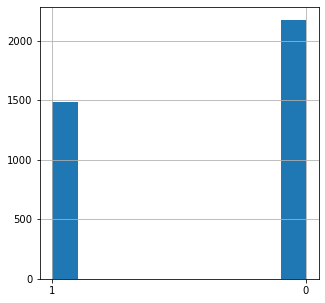

,id_code,diagnosis,path,exists,level
0,000c1434d8d7,2,/home/jupyter/train_images/000c1434d8d7.png,True,1
1,001639a390f0,4,/home/jupyter/train_images/001639a390f0.png,True,1
2,0024cdab0c1e,1,/home/jupyter/train_images/0024cdab0c1e.png,True,0
3,002c21358ce6,0,/home/jupyter/train_images/002c21358ce6.png,True,0
4,005b95c28852,0,/home/jupyter/train_images/005b95c28852.png,True,0
...,...,...,...,...,...
3657,ffa47f6a7bf4,2,/home/jupyter/train_images/ffa47f6a7bf4.png,True,1
3658,ffc04fed30e6,0,/home/jupyter/train_images/ffc04fed30e6.png,True,0
3659,ffcf7b45f213,2,/home/jupyter/train_images/ffcf7b45f213.png,True,1
3660,ffd97f8cd5aa,0,/home/jupyter/train_images/ffd97f8cd5aa.png,True,0


In [3]:
base_image_dir = os.path.join('/home/jupyter')

negative = [0, 1]
positive = [2, 3, 4]

retina_df = pd.read_csv(os.path.join(base_image_dir, 'train.csv'))
retina_df['path'] = retina_df['id_code'].map(lambda x: os.path.join(base_image_dir,'train_images',
                                                         '{}.png'.format(x)))
retina_df['exists'] = retina_df['path'].map(os.path.exists)

retina_df.dropna(inplace = True)
retina_df = retina_df[retina_df['exists']].drop_duplicates()
retina_df['level'] = retina_df['diagnosis'].map(lambda x: str(0) if x in negative else str(1))
# retina_df
retina_df['level'].hist(figsize = (5, 5))
plt.show()
retina_df

In [4]:
IMG_SIZE = 512

def auto_crop(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)

        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        return preprocess_input(img)

Found 3662 validated image filenames belonging to 2 classes.
Found 733 validated image filenames belonging to 2 classes.
(16, 512, 512, 3)
(16, 2)


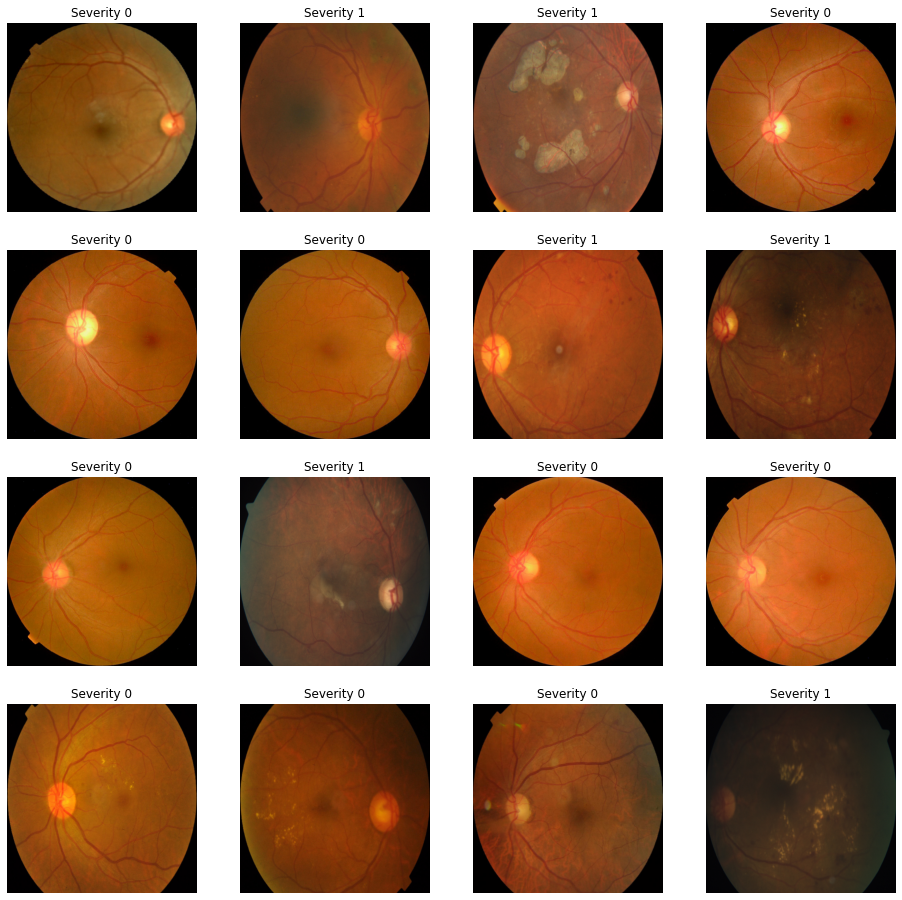

In [5]:
batch_size = 16

train_df, valid_df = train_test_split(retina_df,
                                      test_size = 0.2,
                                      random_state = 2020)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=0, 
    horizontal_flip=True,
    vertical_flip=True, 
    # preprocess_input for no other preprocessing method; 
    # load_ben_color for graham pre-process;
    # auto_crop for auto cropping the image;
    preprocessing_function=auto_crop,
    data_format="channels_last")
train_generator = train_datagen.flow_from_dataframe(retina_df, x_col='path', y_col='level',
                                                    target_size=(IMG_SIZE,IMG_SIZE),
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    class_mode='categorical')

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=0, 
    horizontal_flip=False,
    vertical_flip=False, 
    # preprocess_input for no other preprocessing method; 
    # load_ben_color for graham pre-process;
    # auto_crop for auto cropping the image;
    preprocessing_function=auto_crop,
    data_format="channels_last")
valid_generator = valid_datagen.flow_from_dataframe(valid_df, x_col='path', y_col='level',
                                                    target_size=(IMG_SIZE,IMG_SIZE),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

t_x, t_y = next(train_generator)
input_shape=t_x.shape[1:]
num_classes=t_y.shape[1]
print(t_x.shape)
print(t_y.shape)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')
plt.show()

In [22]:
# train
weight_path="{}_weights_best.hdf5".format('inception_resnet_v2_binary')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor='val_loss', 
                             verbose=1,
                             save_best_only=True, 
                             mode='auto', 
                             save_weights_only=True)

# load the best version of the model
retina_model.load_weights(weight_path)

retina_model.fit(train_generator, 
                 steps_per_epoch = retina_df.shape[0]//batch_size,
                 validation_data = valid_generator,
                 validation_steps = valid_df.shape[0]//batch_size,
                 epochs=30,
                 verbose=1,
                 callbacks = checkpoint,
                 workers = 8
                )



retina_model.save('inception_resnet_v2_binary_retina_model.h5')

Epoch 1/30
228/228 [==============================] - ETA: 0s - loss: 0.0358 - binary_accuracy: 0.9888
Epoch 00001: val_loss improved from inf to 0.35866, saving model to inception_resnet_v2_binary_weights_best.hdf5
228/228 [==============================] - 473s 2s/step - loss: 0.0358 - binary_accuracy: 0.9888 - val_loss: 0.3587 - val_binary_accuracy: 0.9042
Epoch 2/30
228/228 [==============================] - ETA: 0s - loss: 0.0411 - binary_accuracy: 0.9867
Epoch 00002: val_loss improved from 0.35866 to 0.02223, saving model to inception_resnet_v2_binary_weights_best.hdf5
228/228 [==============================] - 469s 2s/step - loss: 0.0411 - binary_accuracy: 0.9867 - val_loss: 0.0222 - val_binary_accuracy: 0.9958
Epoch 3/30
228/228 [==============================] - ETA: 0s - loss: 0.0265 - binary_accuracy: 0.9915
Epoch 00003: val_loss did not improve from 0.02223
228/228 [==============================] - 465s 2s/step - loss: 0.0265 - binary_accuracy: 0.9915 - val_loss: 0.0686 - 

In [8]:
# Validation result recheck block, please firsly run the model block

retina_model.load_weights('inception_resnet_v2_binary_weights_best.hdf5') # load the best weights

retina_model.evaluate(valid_generator,
                      verbose=1,
                      workers=8)

46/46 [==============================] - 55s 1s/step - loss: 0.0214 - binary_accuracy: 0.9918


[0.021402649581432343, 0.9918144345283508]

53576 images found of 53576 total


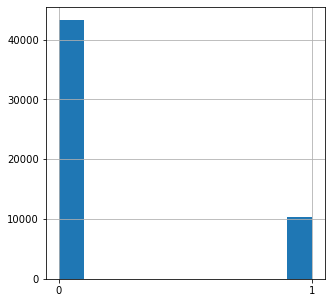

In [2]:
# second stage of training

base_image_dir = os.path.join('/home/jupyter/tensorflow_datasets/downloads/')

negative = [0, 1]
positive = [2, 3, 4]

retina_df = pd.read_csv(os.path.join(base_image_dir, 'labels', 'testLabels15.csv'))
retina_df['path'] = retina_df['image'].map(lambda x: os.path.join(base_image_dir,'resized_test_15',
                                                         '{}.jpg'.format(x)))
retina_df['exists'] = retina_df['path'].map(os.path.exists)
print(retina_df['exists'].sum(), 'images found of', retina_df.shape[0], 'total')

retina_df.dropna(inplace = True)
retina_df = retina_df[retina_df['exists']].drop_duplicates()
retina_df['diagnosis'] = retina_df['level'].map(lambda x: str(0) if x in negative else str(1))
retina_df['diagnosis'].hist(figsize = (5, 5))
plt.show()

In [3]:
config = tf.compat.v1.ConfigProto(gpu_options =
                         tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)


Found 53576 validated image filenames belonging to 2 classes.
Found 53576 validated image filenames belonging to 2 classes.
(16, 512, 512, 3)
(16, 2)


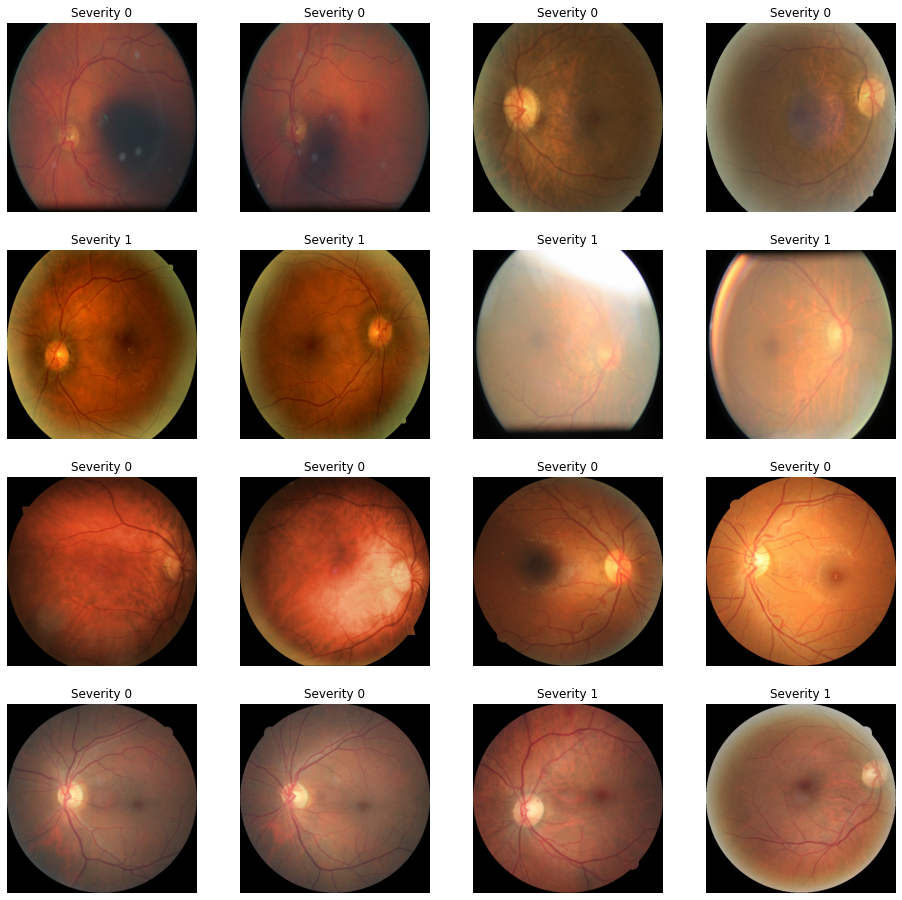

In [4]:
batch_size = 16
IMG_SIZE = 512

train_df, valid_df = train_test_split(retina_df,
                                      test_size = 0.2,
                                      random_state = 2020)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=0, 
    horizontal_flip=True,
    vertical_flip=True, 
    # preprocess_input for no other preprocessing method; 
    # load_ben_color for graham pre-process;
    # auto_crop for auto cropping the image;
    preprocessing_function=preprocess_input,
    data_format="channels_last")
train_generator = train_datagen.flow_from_dataframe(retina_df, 
                                                    x_col='path', 
                                                    y_col='diagnosis',
                                                    target_size=(IMG_SIZE,IMG_SIZE),
                                                    batch_size=batch_size,
                                                    shuffle=False,
                                                    class_mode='categorical')

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=0, 
    horizontal_flip=False,
    vertical_flip=False, 
    # preprocess_input for no other preprocessing method; 
    # load_ben_color for graham pre-process;
    # auto_crop for auto cropping the image;
    preprocessing_function=preprocess_input,
    data_format="channels_last")
valid_generator = valid_datagen.flow_from_dataframe(retina_df, 
                                                    x_col='path', 
                                                    y_col='diagnosis',
                                                    target_size=(IMG_SIZE,IMG_SIZE), 
                                                    batch_size=batch_size,
                                                    shuffle=False,
                                                    class_mode='categorical')

t_x, t_y = next(train_generator)
input_shape=t_x.shape[1:]
num_classes=t_y.shape[1]
print(t_x.shape)
print(t_y.shape)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')
plt.show()

In [5]:
# Model Define
# from tensorflow.keras.applications.xception import Xception as PTModel
# from tensorflow.keras.applications.vgg16 import VGG16 as PTModel
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2 as PTModel
# from tensorflow.keras.applications.inception_v3 import InceptionV3 as PTModel
# from tensorflow.python.keras.applications.efficientnet import EfficientNetB3 as PTModel
# from tensorflow.keras.applications.resnet50 import ResNet50 as PTModel
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from tensorflow.keras import Model

in_lay = Input(t_x.shape[1:])
base_pretrained_model = PTModel(input_shape =  t_x.shape[1:], include_top = False, weights = 'imagenet')

# Turn on and off model trainability
base_pretrained_model.trainable = True
# pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
pt_features = base_pretrained_model(in_lay)
bn_features = BatchNormalization()(pt_features)
gap_dr = GlobalAveragePooling2D()(pt_features)
gap_dr = Dropout(0.2)(gap_dr)
dr_steps = Dropout(0.25)(Dense(128, activation = 'relu')(gap_dr))
out_layer = Dense(t_y.shape[-1], activation = 'sigmoid')(dr_steps)
retina_model = Model(inputs = [in_lay], outputs = [out_layer])


retina_model.compile(optimizer = 'adam', 
                     loss = 'binary_crossentropy',
                     metrics = 'binary_accuracy')
retina_model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 14, 14, 1536)      54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               196736    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                

In [6]:
weight_path="{}_weights_best.hdf5".format('inception_resnet_v2_binary')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor='val_loss', 
                             verbose=1,
                             save_best_only=True, 
                             mode='auto', 
                             save_weights_only=True)

# load the best version of the model
retina_model.load_weights(weight_path)

retina_model.fit(train_generator, 
                 steps_per_epoch = retina_df.shape[0]//batch_size,
                 validation_data = valid_generator,
                 validation_steps = valid_df.shape[0]//batch_size,
                 epochs=10,
                 verbose=1,
                 callbacks = checkpoint,
                 workers = 8
                )



retina_model.save('inception_resnet_v2_binary_retina_model.h5')

Epoch 1/10
3348/3348 [==============================] - ETA: 0s - loss: 0.1600 - binary_accuracy: 0.9424
Epoch 00001: val_loss improved from inf to 0.17123, saving model to inception_resnet_v2_binary_weights_best.hdf5
3348/3348 [==============================] - 5795s 2s/step - loss: 0.1600 - binary_accuracy: 0.9424 - val_loss: 0.1712 - val_binary_accuracy: 0.9365
Epoch 2/10
3348/3348 [==============================] - ETA: 0s - loss: 0.1569 - binary_accuracy: 0.9434
Epoch 00002: val_loss improved from 0.17123 to 0.15045, saving model to inception_resnet_v2_binary_weights_best.hdf5
3348/3348 [==============================] - 5796s 2s/step - loss: 0.1569 - binary_accuracy: 0.9434 - val_loss: 0.1505 - val_binary_accuracy: 0.9444
Epoch 3/10
3348/3348 [==============================] - ETA: 0s - loss: 0.1519 - binary_accuracy: 0.9447
Epoch 00003: val_loss did not improve from 0.15045
3348/3348 [==============================] - 5777s 2s/step - loss: 0.1519 - binary_accuracy: 0.9447 - val_